# Exercise 1

- given the following un-normalized posterior distribution g(θ | x) ∝ 1/2 exp(−(θ + 3)^2)/2 + 1/2 exp(−(θ − 3)^2)/2

- draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm
- use a Norm (0, 1) as random-walk candidate density
- plot the sampled distribution
- analyze the chain with the CODA package and plot the chain autocorrelation

In [1]:
g = function(theta) {0.5 * exp(-((theta + 3)^2) / 2) + 0.5 * exp(-((theta - 3)^2) / 2)}

# algorithm to create samples
metropolis_hastings = function(g, n, init, proposal_sd) {
  
  # allocate the memory for the chain
  theta    <- numeric(n)
  theta[1] <- init
    
  for (i in 2:n) {
      
    proposal <- rnorm(1, mean = theta[i - 1], sd = proposal_sd)
      
    # since the candidate density distribution is symmetric, we can neglect it when calculating the
    # acceptance ratio
    acceptance_ratio = g(proposal) / g(theta[i - 1])
      
    if(runif(1) < acceptance_ratio){theta[i] = proposal} 
    else{theta[i] <- theta[i - 1]}
      
  }
    
  return(theta)
}

Warning message:
“package ‘coda’ was built under R version 4.2.1”


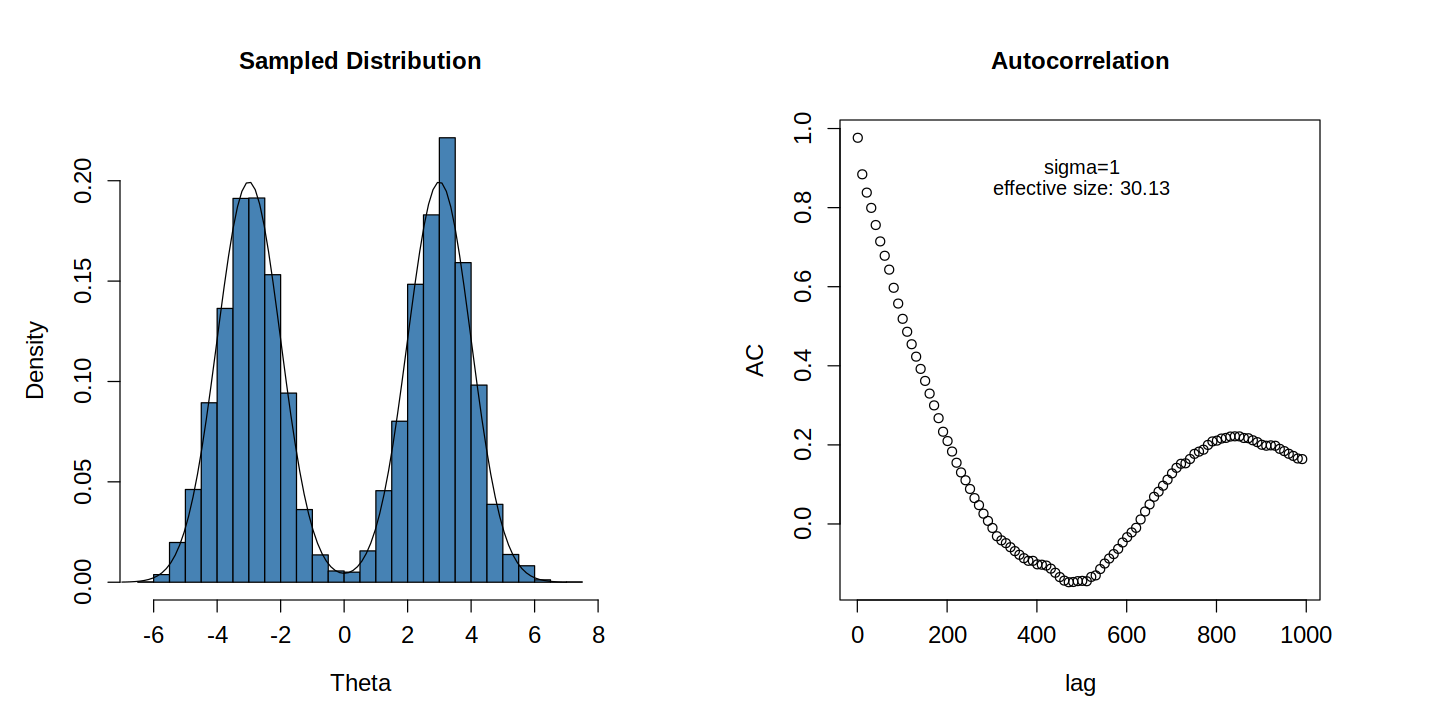

In [2]:
n           <- 10000   # number of samples
init        <- 0       # starting sampling point
proposal_sd <- 1       # standard deviation of the candidate Gaussian function

# Generate the chain
samples <- metropolis_hastings(g, n, init, proposal_sd)

options(repr.plot.width=12, repr.plot.height=6)
# Set the #columns, title size, axis label size, tick label size, margins within plots
par(mfrow = c(1, 2), cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, mar = c(5, 5, 5, 5))    

# Plot the obtained chain (normalised histogram) + the function g(x) 
# (with a little cheat: it is normalised to compare it to the MCMC results)
h = hist(samples, breaks=30, main = "Sampled Distribution", xlab = "Theta", col = "steelblue", freq = FALSE)
curve(g(x) / integrate(function(x) g(x), lower=h$breaks[1], upper=h$breaks[length(h$breaks)])$value, from=-7, to=7, add=TRUE)
                       
# Let's now analyse the autocorrelation
library(coda)

mcmc <- as.mcmc(samples)
lags <- seq(1, n/10, 10)

G <- autocorr(mcmc, lags=lags)

plot(lags, G, xlab='lag', ylab='AC', main="Autocorrelation")
text(n/20,0.9, paste('sigma=1'))
text(n/20,0.85, sprintf("effective size: %.2f", effectiveSize (mcmc)))


- try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?


In [ ]:
# burn-in: first, possibly biased samples eliminated
# thinning: keep only a sample every 'thinning' samples
burn_in  <- c(n/10000, n/1000, n/100, n/10, n/5, n/2)
thinning <- c(1, 5, 10, 100)

for (bi in burn_in){
    
    for (th in thinning){
        
        samples_thinned <- samples[seq(from=bi+1, to=n, by = th)]

        options(repr.plot.width=12, repr.plot.height=6)


        # set the #columns, title size, axis label size, tick label size, margins within plots
        par(mfrow = c(1, 2), cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, mar = c(5, 5, 5, 5))    

        h <- hist(samples_thinned, breaks=30, main = paste("Burn-in", bi, "thinning", th), xlab = "Theta", col = "steelblue", freq = FALSE)
        curve(g(x) / integrate(function(x) g(x), lower=h$breaks[1], upper=h$breaks[length(h$breaks)])$value, from=-7, to=7, add=TRUE)

        mcmc <- as.mcmc(samples_thinned)
        
        if(length(samples_thinned) >= (n-bi)/10){lags = seq(1, n/10, 10)}
        else{lags = seq(1, th)}

        G <- autocorr(mcmc, lags=lags)

        plot(lags[1:length(G)], G, xlab='lag', ylab='AC', main="Autocorrelation")
        text(lags[length(G)]/2,0.3, sprintf("effective size: %.2f", effectiveSize (mcmc)))
    }
}

Based on the analysis of the available data, it appears that burn-in does not seem to have a substantial impact on autocorrelation. Consequently, it is advisable to keep the burn-in period short in order to maximize the acceptance rate of generated samples and conserve computational resources. Conversely, thinning demonstrates significant results even with a modest thinning factor of 5. Notably, the optimal thinning value appears to be approximately 10. However, if the thinning factor is set to 100, the generated samples exhibit poor reproduction of the desired function.

## Exercise 2
The European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having
performed a scientific evaluation of the vaccines efficacy
The following vaccines are currently authorized for use in the European Union:
- Comirnaty (BioNTech and Pfizer)
- VCOVID-19 Vaccine Valneva
- Nuvaxovid (Novavax)
- Pikevax (Moderna)
- Vaxzeviria (AstraZeneca)
- Jcovden (Janssen)
- VidPrevtyn Beta (Sanofi Pasteur)
- Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.) <br> <br>

Analyze the initial test data reported on the EMA Web site for the following early Vaccines <br> 
- Janssen 
- Moderna 
- AstraZeneca 
- Jcovden  

and create a Markow Chain Monte Carlo JAGS or stan the efficacy of each Vaccine. Infere the 95%
credibility interval.

-Spikevax (ex Moderna) https://www.ema.europa.eu/en/documents/overview/spikevax-previously-covid-19-vaccine-moderna-epar-medicine-overview_en.pdf <br>
-Vaxrevia (ex Astrazeneca) https://www.ema.europa.eu/en/documents/overview/vaxzevria-previously-covid-19-vaccine-astrazeneca-epar-medicine-overview_en.pdf <br>
-Jcovden (ex Janssen) https://www.ema.europa.eu/en/documents/overview/jcovden-previously-covid-19-vaccine-janssen-epar-medicine-overview_en.pdf <br>
-Janssen (early reports) https://www.ema.europa.eu/en/documents/assessment-report/covid-19-vaccine-janssen-epar-public-assessment-report_en.pdf


In [1]:
library(tidybayes)
library(rjags)
library(tibble)
library(runjags)
library(dplyr)
library(coda)
library(plotrix)
library(bayestestR)
library(bayesplot)
library(logspline)
install.packages("bayesboot", repos='http://cran.us.r-project.org')
library("bayesboot")
install.packages("mcmcOutput", repos='http://cran.us.r-project.org')
library("mcmcOutput")

Warning message:
“package ‘tidybayes’ was built under R version 4.2.2”
Loading required package: coda

Warning message:
“package ‘coda’ was built under R version 4.2.1”
Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

Warning message:
“package ‘runjags’ was built under R version 4.2.1”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘bayestestR’ was built under R version 4.2.3”

Attaching package: ‘bayestestR’


The following object is masked from ‘package:tidybayes’:

    hdi


This is bayesplot version 1.9.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching pac

We have pretty good information on how likely is to get COVID so we use a beta(3,100) prior.

In [2]:
modelString <- "
    model {
        for (i in 1:Ntot) {
            tested[i] ~ dbern(theta[patient[i]])
        }
        for (k in 1:Nclass) {
            theta[k] ~ dbeta(3,100)
        }
    }"


In [3]:
efficacy = function(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo){
    patient <- c(rep("Vaccine", tot_vaccine ),rep("Placebo", tot_placebo))
    
    tested  <- c(rep("Pos", pos_vaccine), 
                 rep("Neg", tot_vaccine - pos_vaccine), 
                 rep("Pos", pos_placebo),
                 rep("Neg", tot_placebo - pos_placebo))
    
    vaccine.tb <- tibble(tested = tested, patient = patient)
    table(vaccine.tb[[2]], vaccine.tb[[1]])
    
    dataList <- list(tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
                    patient = as.integer(factor(vaccine.tb$patient)), 
                    Ntot = nrow(vaccine.tb), 
                    Nclass = nlevels (factor(vaccine.tb$patient)))

    vaccine_chains <- run.jags(modelString,
                               sample = 15000,
                               n.chains = 4,
                               method = "parallel",
                               monitor = "theta",
                               data = dataList )
    
    #Results
    cat("=========================================================","\n")
    cat("JAGS results:","\n")
    cat("=========================================================","\n")
    print(summary(vaccine_chains))
    
    vaccine_res <- tidybayes::tidy_draws(vaccine_chains) |>
                                select('theta[1]':'theta[2]') |>
                                    rename(Placebo = 'theta[1]', Vaccine ='theta[2]') |>
                                        mutate(diff_rate = ( Placebo - Vaccine ) / Placebo * 100,
                                               Placebo_perc = Placebo * 100,
                                               Vaccine_perc = Vaccine * 100)
    
    allmcmc2 <- as.mcmc(vaccine_res, vars = "diff_rate")
    pt3 <- mcmc_intervals(allmcmc2, prob = 0.95, pars = "diff_rate")
    
    posterior_plot <- mcmc_hist(allmcmc2)

    # Display the posterior plot
    print(posterior_plot)
    
    prior <- bayestestR::distribution_normal(60000, mean = 50, sd = 15) 
    bayestestR::bayesfactor_parameters(vaccine_res$diff_rate,
                                        prior, 
                                        direction = "two-sided", 
                                        null = 50)
}

In [ ]:
cat("=========================================================","\n")
cat("Spikevax results:","\n")
cat("=========================================================","\n")

tot_vaccine <- 14134
tot_placebo <- 14073

# Number of patients tested postive after RCT:
pos_vaccine <- 11
pos_placebo <- 185

efficacy(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo)

Spikevax results: 


Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Sat Jun  3 11:46:28 2023
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

Warning message:
“`prob_outer` (0.9) is less than `prob` (0.95)
... Swapping the values of `prob_outer` and `prob`”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


log_BF
<dbl>
33.93488


In [ ]:
cat("=========================================================","\n")
cat("Vaxzrevia results:","\n")
cat("=========================================================","\n")

tot_vaccine <- 17662
tot_placebo <- 8550 

# Number of patients tested postive after RCT:
pos_vaccine <- 73
pos_placebo <- 130

efficacy(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo)

In [ ]:
cat("=========================================================","\n")
cat("Jcovden results:","\n")
cat("=========================================================","\n")

tot_vaccine <- 19630 
tot_placebo <- 19691  

# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348

efficacy(tot_vaccine, tot_placebo, pos_vaccine, pos_placebo)

## Exercise 3
According to the official COVID-19 vaccination data, 70% of the world population has received at
least one dose of a COVID-19 vaccine.  <br> A global vaccination dataset is available. <br>
The European Centre for Disease Prevention and Control published a downloadable file containing
information on COVID-19 vaccination in the EU/EEA. <br>

Analyze the data and produce the following plots:
- number of vaccinated people (cumulative, daily and week average)
- number of confirmed deaths by COVID-19, both cumulative and weekly average

In [ ]:
library(dplyr)
library(ggplot2)

options(repr.plot.width=15, repr.plot.height=10)

In [ ]:
file <- "owid-covid-data.csv"

df <- read.csv(file, stringsAsFactors = FALSE)

# Convert all columns except the first four to numeric
df <- df |>
  mutate_at(vars(-(1:4)), as.numeric)

# Convert NA to 0
df[is.na(df)] <- 0

In [ ]:
# Create a new dataset with rows where 'location' is equal to 'World'
world <- df[df$location == "World", ]

# Convert the date column to a proper date format
world$date <- as.Date(world$date)

In [ ]:
# Extract only the 'total_deaths' and 'new_deaths' columns
deaths <- world[, c("date", "total_deaths", "new_deaths")]
deaths$date <- as.Date(deaths$date)

# Same for 'total_vaccinations' and 'people_vaccinated' columns
vaccines <- world[, c("date", "total_vaccinations", "people_vaccinated", "new_vaccinations")]
vaccines$date <- as.Date(vaccines$date)

In [ ]:
# Plot the cumulative number of vaccinated people (!total_vaccinations include also double/triple doses)
plot(vaccines$date, vaccines$people_vaccinated, col="darkorchid", lwd= 4,  type = "l", xlab = "Date", ylab = "Cumulative Vaccines", main = "Vaccinated people")

In [ ]:
# Calculate the daily difference in people vaccinated
vaccines$daily_diff <- c(0, diff(vaccines$people_vaccinated))

# This "clean-up" is needed because some big countries (e.g. China) submitted the number of vaccinated people 
# every once in a while and that resulted in peaks not representing the real situation
vaccines <- vaccines[vaccines$daily_diff < 100000000, ]

# Daily vaccinated people
plot(vaccines$date, vaccines$daily_diff , col="darkorchid", type = "l", xlab = "Date", ylab = "Vaccinations", main = "Daily vaccinated people")

In [ ]:
# Extract the year from the date
vaccines$year <- format(vaccines$date, "%Y")

# Calculate the week number of the year including the year information (format year-n_week)
vaccines$week_number <- paste(vaccines$year, format(vaccines$date, "%U"), sep = "-")

# Calculate the weekly average of vaccines
vaccines |>
  group_by(week_number) |>
  summarise(week_number, avg_week_v=mean(daily_diff)) -> avg_week_vaccines

In [ ]:
ggplot(avg_week_vaccines, aes(y=avg_week_v, x=week_number)) +
        geom_point(color = "darkorchid")+theme_bw(base_size=15) +
        labs(y= "Weekly Average Vaccinated people", title="Weekly Average of vaccinated people", x="Year-Week number") +
        theme(plot.title=element_text(hjust=0.5)) +
        scale_x_discrete(
            breaks = avg_week_vaccines$week_number[seq(1, nrow(avg_week_vaccines), by = 100)],  # Set the breaks with a specific interval
            labels = avg_week_vaccines$week_number[seq(1, nrow(avg_week_vaccines), by = 100)]  
        )

In [ ]:
# Plot the cumulative number of deaths
plot(deaths$date, deaths$total_deaths, col="darkorchid", lwd= 4, type = "l", xlab = "Date", ylab = "Cumulative Deaths", main = "Deaths")

In [ ]:
# Extract the year from the date
deaths$year <- format(deaths$date, "%Y")

# Calculate the week number of the year including the year information
deaths$week_number <- paste(deaths$year, format(deaths$date, "%U"), sep = "-")

# Calculate the weekly average of deaths
deaths |>
  group_by(week_number) |>
  summarise(week_number, avg_week_d=mean(new_deaths)) -> avg_week_deaths


In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(avg_week_deaths, aes(y=avg_week_d, x=week_number)) +
        geom_point()+theme_bw(base_size=15) +
        labs(y= "Weekly Average Deaths", title="Weekly Average of Deaths") +
        theme(plot.title=element_text(hjust=0.5)) +
        scale_x_discrete(
            breaks = avg_week_deaths$week_number[seq(1, nrow(avg_week_deaths), by = 70)],  # Set the breaks with a specific interval
            labels = avg_week_deaths$week_number[seq(1, nrow(avg_week_deaths), by = 70)]   
        )